### In this notebook ill be implementing an advanced tranformer using keras 

to start what is a transformer ?

it was introduced from the paper "attention is all you need". it uses self attentio mechanisms which we will be implementing them in this notebook.

#### the key compnents: 
* input embedding: converts input tokens into vectors. 
* positional encoding: injects information about the position of input tokens. 
* multi-head self-attention: allows the model to focus on diff parts of the input sequence. 
* feedforward layers: process the attended information. 
* layer normalization & residual connections: Stabilize and speed up training.       

In [8]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 
# will use this library to get real world data 
import yfinance as yf 


In [9]:
## first off lets make the data that we'll be making the data and using the ticket from apple 

ticker = "AAPL"

df = yf.download(ticker, start="2023-01-01", end="2026-01-01")

print(f"real data for {ticker} loaded succesfully")
print(df.head())

#df.to_csv("apple_stock_prices.csv")



[*********************100%***********************]  1 of 1 completed

real data for AAPL loaded succesfully
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.096001  128.833979  122.210204  128.223770  112117500
2023-01-04  124.365669  126.629372  123.105873  124.887303   89113600
2023-01-05  123.046814  125.753411  122.790923  125.123513   80962700
2023-01-06  127.574196  128.233619  122.918854  124.021180   87754700
2023-01-09  128.095840  131.304398  127.839949  128.410797   70790800


In [10]:
## after we got the data we need to load the data 

df = pd.read_csv('apple_stock_prices.csv')
# ill be only taking into account 
df = df[['Close']].values
df= df[2:]


# then we are going to normalize the data 
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)

# prepare the data for training 
def create_dataset(df, time_step=1): 
    X, y = [], []

    for i in range(len(df) - time_step - 1): 
         a = df[i:(i+time_step), 0]
         X.append(a)
         y.append(df[i + time_step, 0])

    return np.array(X), np.array(y)

time_step = 600 

X, y = create_dataset (df, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print(f"Shape of X {X.shape}")
print(f"Shape of y {y.shape}")




 

Shape of X (151, 600, 1)
Shape of y (151,)


In [19]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

 

In [20]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

In [21]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 



In [22]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

(1, 100, 128)


In [23]:

embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 600, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_120 (Dense)               │ (None, 600, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, 600, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 76800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_121 (Dense)               │ (None, 1)              │        76,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 870,145 (3.32 MB)

 Trainable params: 870,145 (3.32 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the model
model.fit(X, y, epochs=20, batch_size=32)
 

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 643.5637
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 157.8311
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 68.4490
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 50.3087
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 23.5270
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 13.0458
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 10.3237
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 6.1504
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 2.5318
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 2.2988
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 1.1665
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.7602
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.7036
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.5278
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - loss: 0.5452
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 663ms/step


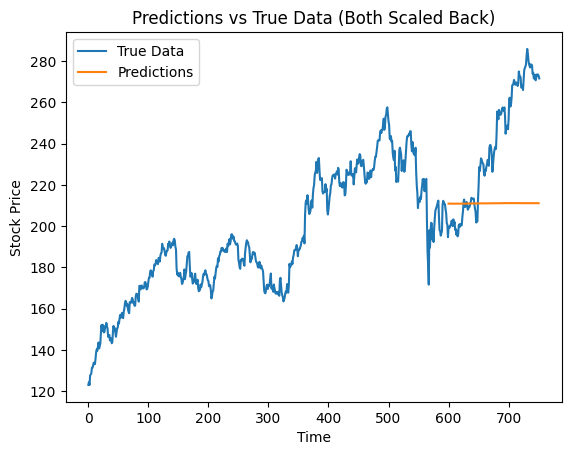

In [27]:
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

# Prepare true values for comparison
true_values = scaler.inverse_transform(df.reshape(-1, 1))

# Plot the predictions vs true values
import matplotlib.pyplot as plt 

plt.plot(true_values, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show() 
